# Cascade Training for Viola-Jones Face Detector

Train 2-stage cascade classifier to reduce false positives.

**V1 Configuration**:
- Stage 1: T=10 (reject ~50% non-faces, keep >99% faces)
- Stage 2: T=40 (final discriminative stage)
- Combined: High detection rate with low FP rate

**AI Usage**: Notebook structure assisted by Claude Code

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from classifiers.cascade import train_cascade, evaluate_cascade, CascadeClassifier
from features.haar_features import generate_haar_features

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Pre-computed Data

In [11]:
print("Loading dataset labels...")

# Load training data
with open('../data/processed/train_faces.pkl', 'rb') as f:
    train_faces = pickle.load(f)

with open('../data/processed/train_nonfaces.pkl', 'rb') as f:
    train_nonfaces = pickle.load(f)

# Create labels
y_train = np.concatenate([
    np.ones(len(train_faces), dtype=int),
    np.zeros(len(train_nonfaces), dtype=int)
])

# Load testing data
with open('../data/processed/test_faces.pkl', 'rb') as f:
    test_faces = pickle.load(f)

with open('../data/processed/test_nonfaces.pkl', 'rb') as f:
    test_nonfaces = pickle.load(f)

y_test = np.concatenate([
    np.ones(len(test_faces), dtype=int),
    np.zeros(len(test_nonfaces), dtype=int)
])

print(f"Training: {len(train_faces)} faces, {len(train_nonfaces)} non-faces")
print(f"Testing: {len(test_faces)} faces, {len(test_nonfaces)} non-faces")

Loading dataset labels...
Training: 799 faces, 3995 non-faces
Testing: 2260 faces, 11300 non-faces


In [12]:
# Load pre-computed feature responses
print("\nLoading pre-computed feature responses...")
train_responses = np.load('../data/processed/train_responses_10k.npy')
test_responses = np.load('../data/processed/test_responses_10k.npy')

print(f"Training responses: {train_responses.shape}")
print(f"Testing responses: {test_responses.shape}")


Loading pre-computed feature responses...
Training responses: (4794, 10000)
Testing responses: (13560, 10000)
Training responses: (4794, 10000)
Testing responses: (13560, 10000)


In [13]:
# Load features
print("\nGenerating Haar features (same as training)...")
features = generate_haar_features(window_size=16, max_features=10000)
print(f"Generated {len(features)} features")


Generating Haar features (same as training)...
Generating Haar features for 16×16 window...
  Generating 2-rectangle horizontal features...
  Generating 2-rectangle vertical features...
Generated 10000 features


## 2. Define Cascade Configuration

**2-Stage Cascade**:
- Stage 1: Fast filter (T=10, high recall)
- Stage 2: Discriminative (T=40, balanced)

In [14]:
stage_configs = [
    {
        'T': 10,
        'target_fpr': 0.5,    # Reject 50% of non-faces
        'target_tpr': 0.995   # Keep 99.5% of faces
    },
    {
        'T': 40,
        'target_fpr': 0.01,   # Very low FP rate for final stage
        'target_tpr': 0.99    # 99% face detection
    }
]

print("Cascade Configuration:")
for i, config in enumerate(stage_configs, 1):
    print(f"  Stage {i}: T={config['T']}, FPR={config['target_fpr']:.1%}, TPR={config['target_tpr']:.1%}")

Cascade Configuration:
  Stage 1: T=10, FPR=50.0%, TPR=99.5%
  Stage 2: T=40, FPR=1.0%, TPR=99.0%


## 3. Train Cascade

**This will take several minutes**
- Stage 1: Train on full dataset
- Stage 2: Train on faces + FPs from Stage 1

In [15]:
cascade = train_cascade(
    train_responses,
    y_train,
    features,
    stage_configs,
    verbose=True
)

Training Cascade with 2 stages

Training Stage 1/2
  T=10 weak classifiers
  Target FPR: 50.0%, Target TPR: 99.5%
  Training samples: 4794
    Faces: 799
    Non-faces: 3995
Training AdaBoost with T=10 rounds
  Samples: 4794 (negatives: 3995, positives: 799)

Initial weights sum: 1.000000
  Negative samples: 3995 x 0.000125 = 0.500000
  Positive samples: 799 x 0.000626 = 0.500000

--- Round 1/10 ---
  Normalized weights sum: 1.000000
  Searching 10000 features for best weak classifier...
    Evaluated 1000/10000 features...
    Evaluated 1000/10000 features...
    Evaluated 2000/10000 features...
    Evaluated 2000/10000 features...
    Evaluated 3000/10000 features...
    Evaluated 3000/10000 features...
    Evaluated 4000/10000 features...
    Evaluated 4000/10000 features...
    Evaluated 5000/10000 features...
    Evaluated 5000/10000 features...
    Evaluated 6000/10000 features...
    Evaluated 6000/10000 features...
    Evaluated 7000/10000 features...
    Evaluated 7000/10000 f

## 4. Evaluate on Training Set

In [16]:
print("\nEvaluating cascade on TRAINING set...")
train_metrics = evaluate_cascade(cascade, train_responses, y_train, verbose=True)


Evaluating cascade on TRAINING set...

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  81.75%
  Precision: 47.70%
  Recall:    98.75%
  F1 Score:  64.33%

Confusion Matrix:
  TP:   789  FP:   865
  FN:    10  TN:  3130

Cascade Stage Statistics:
  Stage 1:  4794 samples,  1824 rejected (38.0%)
  Stage 2:  2970 samples,  1316 rejected (44.3%)

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  81.75%
  Precision: 47.70%
  Recall:    98.75%
  F1 Score:  64.33%

Confusion Matrix:
  TP:   789  FP:   865
  FN:    10  TN:  3130

Cascade Stage Statistics:
  Stage 1:  4794 samples,  1824 rejected (38.0%)
  Stage 2:  2970 samples,  1316 rejected (44.3%)


## 5. Evaluate on Test Set

In [17]:
print("\nEvaluating cascade on TEST set...")
test_metrics = evaluate_cascade(cascade, test_responses, y_test, verbose=True)


Evaluating cascade on TEST set...

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  74.92%
  Precision: 39.04%
  Recall:    89.91%
  F1 Score:  54.44%

Confusion Matrix:
  TP:  2032  FP:  3173
  FN:   228  TN:  8127

Cascade Stage Statistics:
  Stage 1: 13560 samples,  4784 rejected (35.3%)
  Stage 2:  8776 samples,  3571 rejected (40.7%)

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  74.92%
  Precision: 39.04%
  Recall:    89.91%
  F1 Score:  54.44%

Confusion Matrix:
  TP:  2032  FP:  3173
  FN:   228  TN:  8127

Cascade Stage Statistics:
  Stage 1: 13560 samples,  4784 rejected (35.3%)
  Stage 2:  8776 samples,  3571 rejected (40.7%)


## 6. Save Cascade Model

In [18]:
model_path = Path('../data/models/cascade_v1_2stage.pkl')
cascade.save(model_path)
print(f"\nCascade saved to {model_path}")

Saved cascade to ..\data\models\cascade_v1_2stage.pkl

Cascade saved to ..\data\models\cascade_v1_2stage.pkl


## 7. Compare with Single AdaBoost

In [19]:
# Load and compare with single AdaBoost
from classifiers.adaboost import AdaBoostClassifier, evaluate_classifier

adaboost_path = Path('../data/models/adaboost_v1_T50.pkl')
if adaboost_path.exists():
    print("Loading single AdaBoost model for comparison...")
    adaboost = AdaBoostClassifier.load(adaboost_path)
    
    print("\nSingle AdaBoost (T=50) on TEST set:")
    adaboost_metrics = evaluate_classifier(adaboost, test_responses, y_test, verbose=True)
    
    # Comparison table
    print("\n" + "=" * 60)
    print("COMPARISON: Cascade vs Single AdaBoost")
    print("=" * 60)
    print(f"{'Metric':<15} {'Cascade':<15} {'AdaBoost T=50':<15}")
    print("-" * 60)
    print(f"{'Accuracy':<15} {test_metrics['accuracy']:<15.2%} {adaboost_metrics['accuracy']:<15.2%}")
    print(f"{'Precision':<15} {test_metrics['precision']:<15.2%} {adaboost_metrics['precision']:<15.2%}")
    print(f"{'Recall':<15} {test_metrics['recall']:<15.2%} {adaboost_metrics['recall']:<15.2%}")
    print(f"{'F1 Score':<15} {test_metrics['f1']:<15.2%} {adaboost_metrics['f1']:<15.2%}")
    print("=" * 60)
else:
    print("Single AdaBoost model not found. Train it first using 03_adaboost_training.ipynb")

Loading single AdaBoost model for comparison...

Single AdaBoost (T=50) on TEST set:

Evaluation Metrics
Accuracy:  84.97%
Precision: 53.34%
Recall:    78.45%
F1 Score:  63.50%

Confusion Matrix:
  TP:  1773  FP:  1551
  FN:   487  TN:  9749

COMPARISON: Cascade vs Single AdaBoost
Metric          Cascade         AdaBoost T=50  
------------------------------------------------------------
Accuracy        74.92%          84.97%         
Precision       39.04%          53.34%         
Recall          89.91%          78.45%         
F1 Score        54.44%          63.50%         


## 8. Visualize Cascade Performance

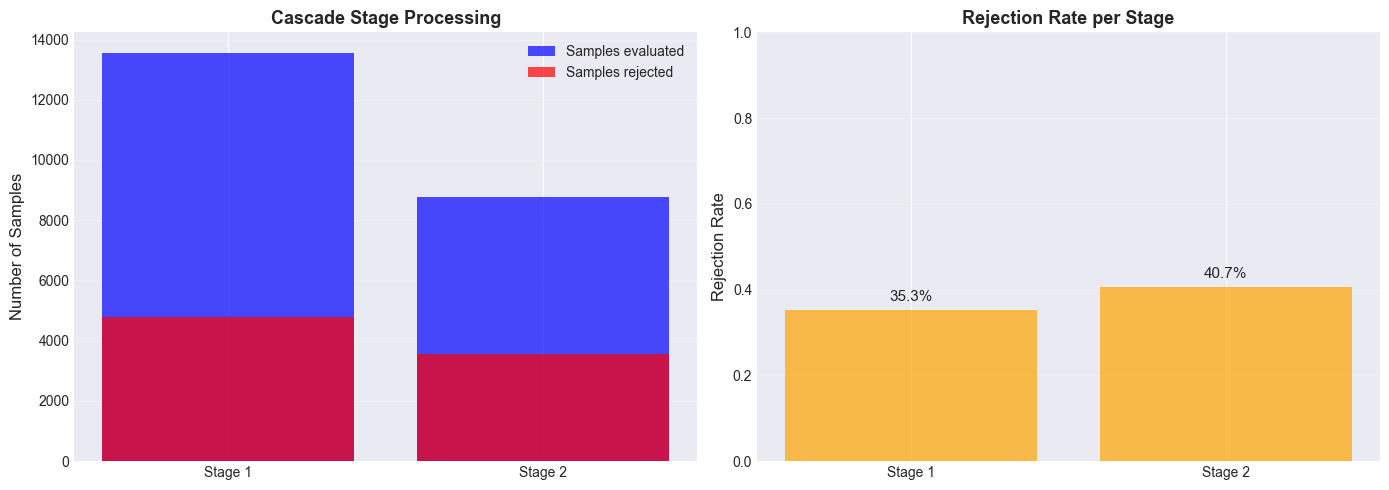

In [20]:
# Stage-by-stage rejection rates
stage_info = test_metrics['stage_info']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot: samples per stage
stages = [f'Stage {i+1}' for i in range(len(stage_info['samples_per_stage']))]
samples = stage_info['samples_per_stage']
rejections = stage_info['rejections_per_stage']

axes[0].bar(stages, samples, alpha=0.7, label='Samples evaluated', color='blue')
axes[0].bar(stages, rejections, alpha=0.7, label='Samples rejected', color='red')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Cascade Stage Processing', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Rejection rates
rejection_rates = [r/s if s > 0 else 0 for r, s in zip(rejections, samples)]
axes[1].bar(stages, rejection_rates, alpha=0.7, color='orange')
axes[1].set_ylabel('Rejection Rate', fontsize=12)
axes[1].set_title('Rejection Rate per Stage', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (stage, rate) in enumerate(zip(stages, rejection_rates)):
    axes[1].text(i, rate + 0.02, f'{rate:.1%}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/cascade_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Results Summary

In [21]:
print("=" * 60)
print("CASCADE V1 RESULTS SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Stages: {len(cascade.stages)}")
print(f"  Total weak classifiers: {sum(len(s.classifier.weak_classifiers) for s in cascade.stages)}")
for i, stage in enumerate(cascade.stages, 1):
    print(f"    Stage {i}: {len(stage.classifier.weak_classifiers)} weak classifiers, threshold={stage.threshold:.4f}")

print(f"\nTest Performance:")
print(f"  Accuracy:  {test_metrics['accuracy']:.2%}")
print(f"  Precision: {test_metrics['precision']:.2%}")
print(f"  Recall:    {test_metrics['recall']:.2%}")
print(f"  F1 Score:  {test_metrics['f1']:.2%}")

print(f"\nComputational Efficiency:")
total_samples = stage_info['samples_per_stage'][0]
for i, n_samples in enumerate(stage_info['samples_per_stage'], 1):
    pct = n_samples / total_samples if total_samples > 0 else 0
    print(f"  Stage {i}: {pct:.1%} of samples evaluated")

print("\n" + "=" * 60)
if test_metrics['accuracy'] >= 0.70:
    print("[OK] V1 Complete! Cascade achieves >70% accuracy")
else:
    print("Note: Consider tuning thresholds or adding more stages")
print("=" * 60)

CASCADE V1 RESULTS SUMMARY

Configuration:
  Stages: 2
  Total weak classifiers: 50
    Stage 1: 10 weak classifiers, threshold=0.3068
    Stage 2: 40 weak classifiers, threshold=0.4406

Test Performance:
  Accuracy:  74.92%
  Precision: 39.04%
  Recall:    89.91%
  F1 Score:  54.44%

Computational Efficiency:
  Stage 1: 100.0% of samples evaluated
  Stage 2: 64.7% of samples evaluated

[OK] V1 Complete! Cascade achieves >70% accuracy


## Next Steps

1. **V1 Milestone**: If accuracy >70%, Part 1 implementation complete!
2. **V2 Scale-up**: Increase to 50k features, T=200, more cascade stages
3. **Part 2**: Implement sliding window detection on full images
4. **Report**: Document algorithm, results, and analysis